In [1]:
# ✅ STEP 1: Install Libraries
!pip install transformers datasets scikit-learn matplotlib --quiet

In [2]:
import pandas as pd
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
print(df.columns)
df.head()

/tmp/ipython-input-2-724997243.py:2: ParserWarning: Skipping line 22006: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]  # Remove neutral
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [4]:
df = df.sample(15000)

In [5]:
# ✅ STEP 4: Split into Train/Test
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'], df['label'], test_size=0.2, random_state=42
)

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
import torch

class AmazonDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    return{key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

  def __len__(self):
    return len(self.labels)

train_dataset = AmazonDataset(train_encodings, train_labels.tolist())
val_dataset = AmazonDataset(val_encodings, val_labels.tolist())

In [8]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import os, time

# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch", # Corrected argument name
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"  # Don't save checkpoints to save time
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


start_time = time.time()
trainer.train()
training_time = time.time() - start_time

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.131200,0.168516
2,0.133800,0.228778


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Time testing
start_test = time.time()
predictions = trainer.predict(val_dataset)
test_time = time.time() - start_test

y_pred = predictions.predictions.argmax(axis=-1)
y_true = val_labels

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")


Accuracy: 0.9375
Precision: 0.9506726457399103
Recall: 0.9739663093415007
F1 Score: 0.962178517397882
Training Time: 144.22 seconds
Testing Time: 5.10 seconds


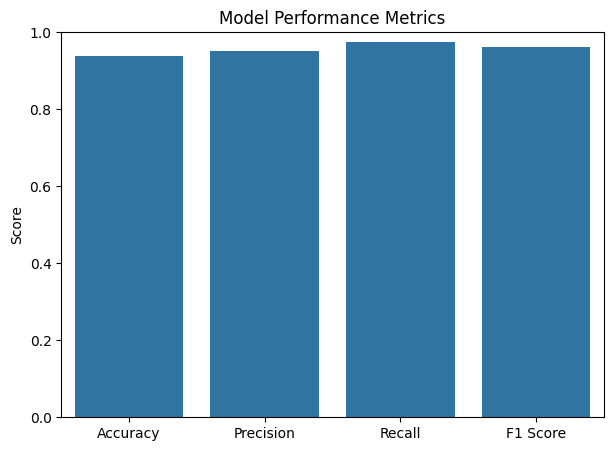

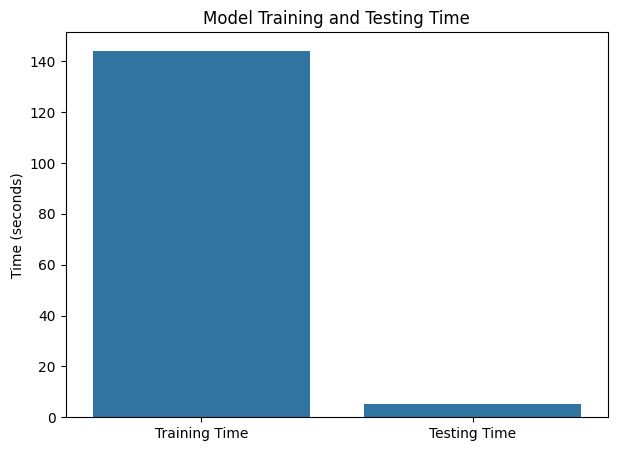

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [acc, prec, rec, f1]

# Plotting the metrics
plt.figure(figsize=(7, 5))
sns.barplot(x=metrics_names, y=metrics_values)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Set y-axis limits to be between 0 and 1 for scores
plt.show()

# Data for the time chart
time_names = ['Training Time', 'Testing Time']
time_values = [training_time, test_time]

# Plotting the times
plt.figure(figsize=(7, 5))
sns.barplot(x=time_names, y=time_values)
plt.title('Model Training and Testing Time')
plt.ylabel('Time (seconds)')
plt.show()
